Device: cuda
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


d:\Anaconda\envs\plant\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Anaconda\envs\plant\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Phase A Epoch [1/10] Train Loss: 0.5232 | Train Acc: 0.7607 | Val Loss: 0.2339 | Val Acc: 0.8596
Phase A Epoch [2/10] Train Loss: 0.2391 | Train Acc: 0.8581 | Val Loss: 0.1752 | Val Acc: 0.8936
Phase A Epoch [3/10] Train Loss: 0.2017 | Train Acc: 0.8728 | Val Loss: 0.1677 | Val Acc: 0.8873
Phase A Epoch [4/10] Train Loss: 0.1852 | Train Acc: 0.8815 | Val Loss: 0.1694 | Val Acc: 0.8863
Phase A Epoch [5/10] Train Loss: 0.1727 | Train Acc: 0.8880 | Val Loss: 0.1121 | Val Acc: 0.9247
Phase A Epoch [6/10] Train Loss: 0.1653 | Train Acc: 0.8931 | Val Loss: 0.0993 | Val Acc: 0.9334
Phase A Epoch [7/10] Train Loss: 0.1548 | Train Acc: 0.8977 | Val Loss: 0.1268 | Val Acc: 0.9184
Phase A Epoch [8/10] Train Loss: 0.1631 | Train Acc: 0.8901 | Val Loss: 0.1220 | Val Acc: 0.9213
Phase A Epoch [9/10] Train Loss: 0.1483 | Train Acc: 0.9008 | Val Loss: 0.1299 | Val Acc: 0.9111
Phase A Epoch [10/10] Train Loss: 0.1476 | Train Acc: 0.9021 | Val Loss: 0.1562 | Val Acc: 0.9048
Phase B Epoch [1/5] Train Los

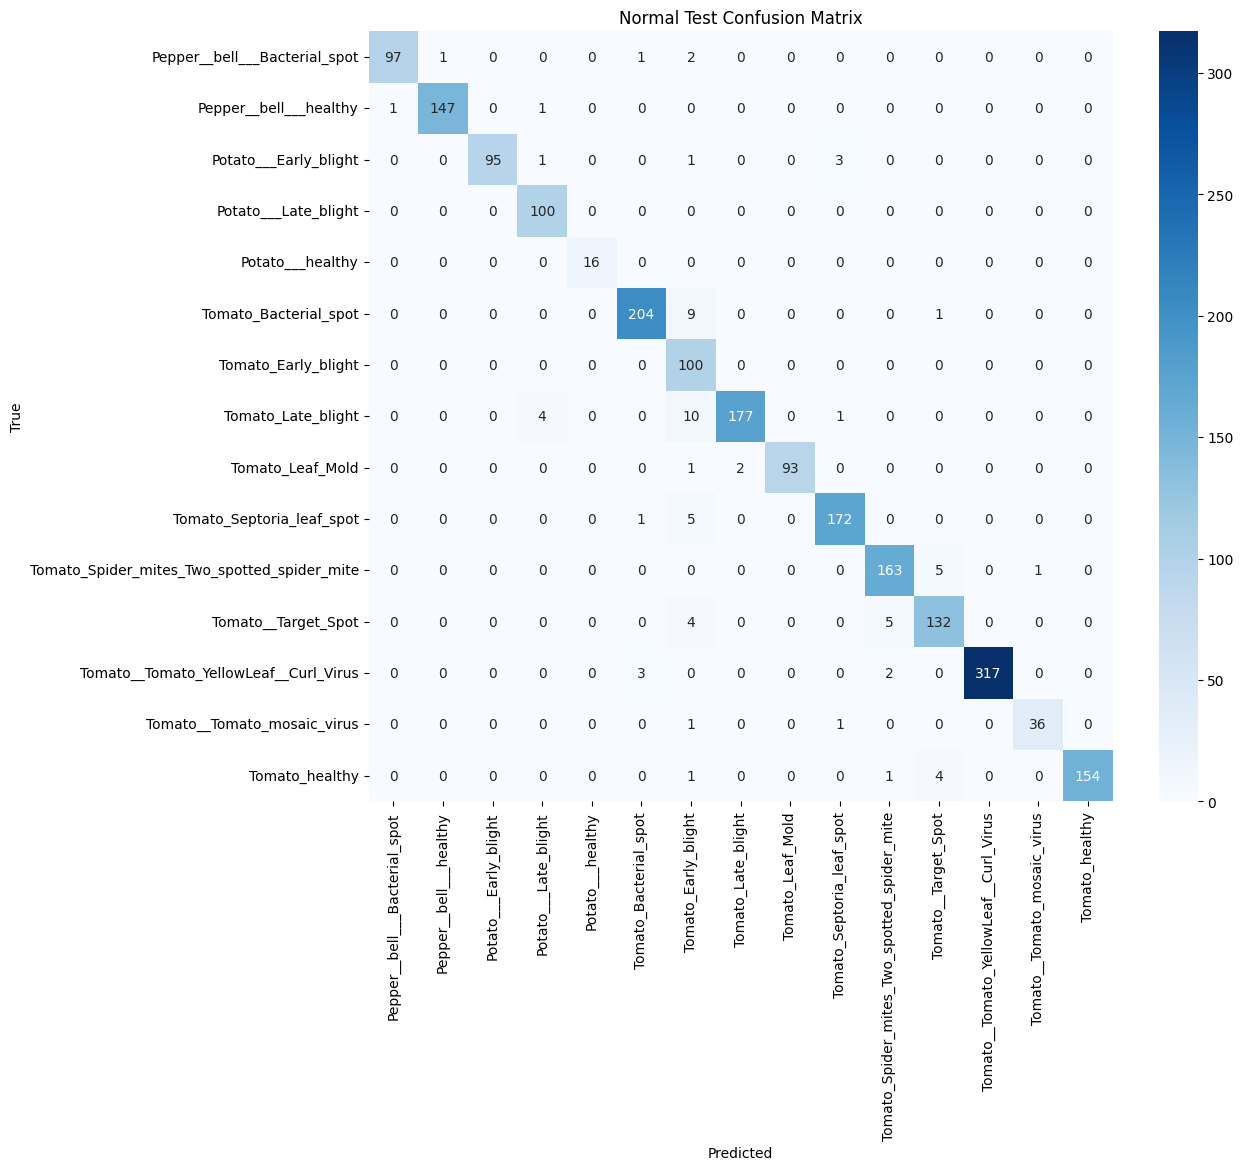

Hard Aug Test Accuracy: 0.0963

=== Hard Aug Test Classification Report ===
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot     0.1111    0.0099    0.0182       101
                     Pepper__bell___healthy     0.0000    0.0000    0.0000       149
                      Potato___Early_blight     0.0000    0.0000    0.0000       100
                       Potato___Late_blight     0.0000    0.0000    0.0000       100
                           Potato___healthy     0.0000    0.0000    0.0000        16
                      Tomato_Bacterial_spot     0.0000    0.0000    0.0000       214
                        Tomato_Early_blight     0.0625    0.0100    0.0172       100
                         Tomato_Late_blight     0.0941    0.9844    0.1718       192
                           Tomato_Leaf_Mold     0.1579    0.0625    0.0896        96
                  Tomato_Septoria_leaf_spot     0.6000    0.0169    0.032

d:\Anaconda\envs\plant\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Anaconda\envs\plant\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Anaconda\envs\plant\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


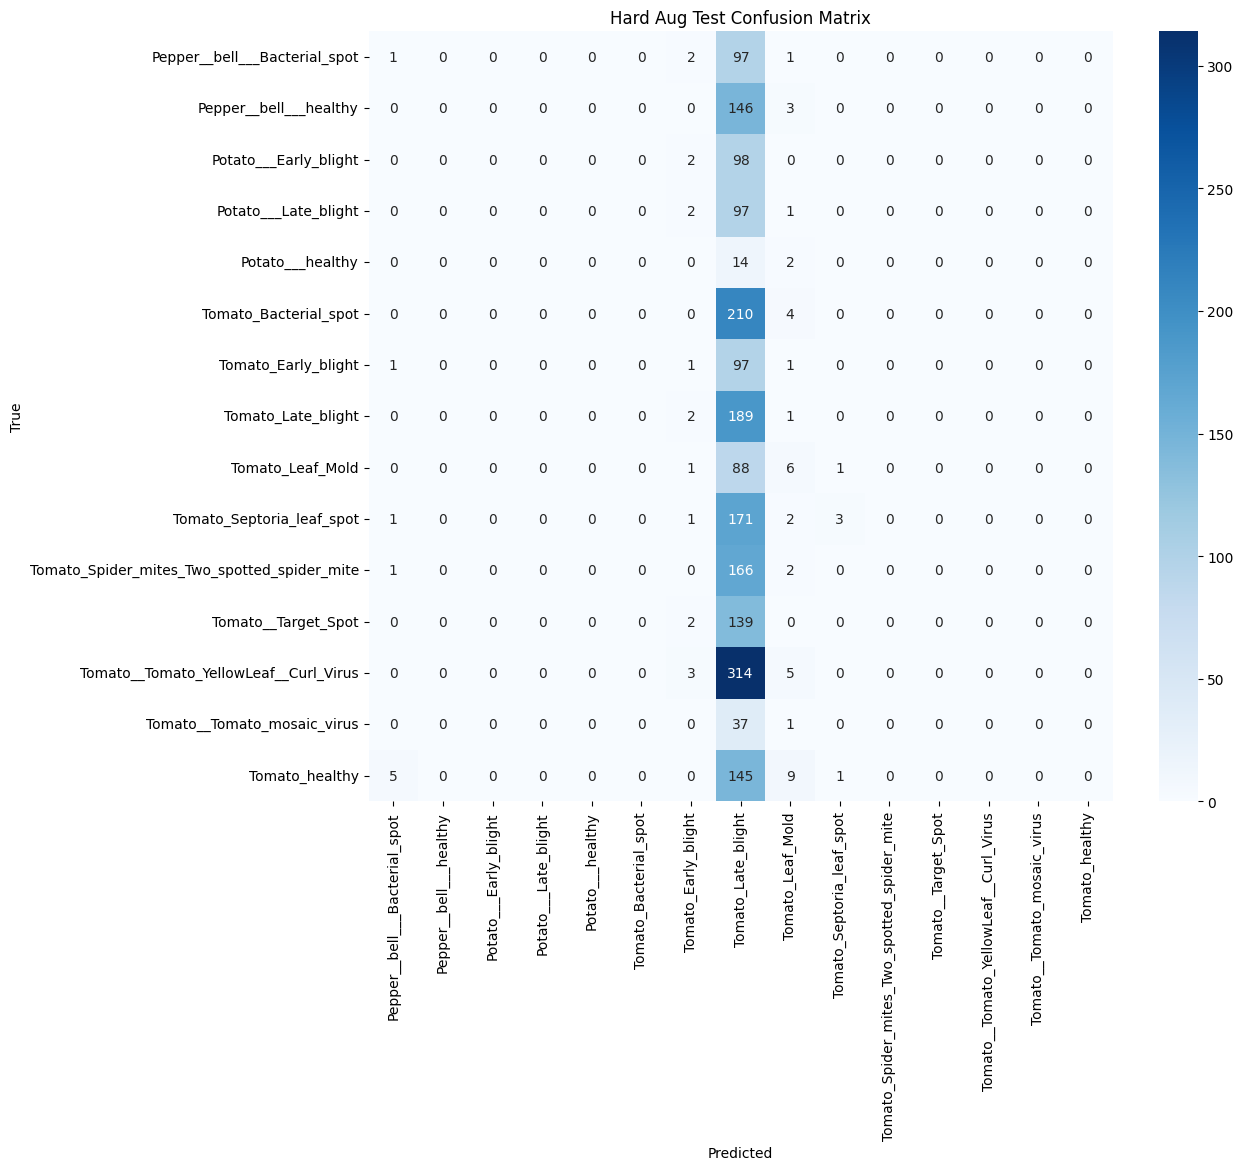

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Config


BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS_PHASE_A = 10   
EPOCHS_PHASE_B = 5    
LR_PHASE_A = 1e-3
LR_PHASE_B = 1e-4
DATA_ROOT = r"D:\dataset_split"
N_LAST_LAYERS = 20  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# Data Augmentation

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale = (0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root = f"{DATA_ROOT}/train", transform = train_transform)
val_dataset   = datasets.ImageFolder(root = f"{DATA_ROOT}/val", transform = val_transform)
test_dataset  = datasets.ImageFolder(root = f"{DATA_ROOT}/test", transform = val_transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader   = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

# Focal Loss

class FocalLoss(nn.Module):
    def __init__(self, alpha = 1, gamma = 2, reduction = "mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction = "none")(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

criterion = FocalLoss()


# Model: ResNet50

resnet = models.resnet50(pretrained = True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
model = resnet.to(device)

# Training Function

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, phase_name = "Phase"):
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss, running_correct = 0.0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            running_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        print(f"{phase_name} Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    return model

# Phase A: Train classifier

for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr = LR_PHASE_A)
model = train_model(model, criterion, optimizer, train_loader, val_loader,
                    epochs = EPOCHS_PHASE_A, phase_name = "Phase A")

# Phase B: Fine-tuning last N layers

for name, param in model.named_parameters():
    param.requires_grad = False
for name, param in list(model.named_parameters())[-N_LAST_LAYERS:]:
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = LR_PHASE_B)
model = train_model(model, criterion, optimizer, train_loader, val_loader,
                    epochs = EPOCHS_PHASE_B, phase_name = "Phase B")


# Evaluation & Report

def evaluate_and_report(y_true, y_pred, class_names, desc = "Test"):
    print(f"\n=== {desc} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names = class_names, digits = 4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (12, 10))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues",
                xticklabels = class_names, yticklabels = class_names)
    plt.title(f"{desc} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Normal Test
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
normal_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"\nNormal Test Accuracy: {normal_acc:.4f}")
evaluate_and_report(all_labels, all_preds, test_dataset.classes, desc = "Normal Test")

# Hard Aug Test
hard_test_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale = (0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(0.5, 0.5, 0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
hard_test_dataset = datasets.ImageFolder(f"{DATA_ROOT}/test", transform = hard_test_transform)
hard_test_loader = DataLoader(hard_test_dataset, batch_size = BATCH_SIZE, shuffle = False)

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in hard_test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
hard_acc = (all_preds == all_labels).sum() / len(all_labels)
print(f"Hard Aug Test Accuracy: {hard_acc:.4f}")
evaluate_and_report(all_labels, all_preds, test_dataset.classes, desc = "Hard Aug Test")

# Save model

torch.save(model.state_dict(), "D:/saved_models/resnet50_finetuned_focalloss.pt")
